# Local Outlier Factor 
### Author: Cristina Afanasii

### 1. Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import LocalOutlierFactor
from src.data.synthetic_anomalies.anomalies import NoiseMachine


### 2. Utils

In [19]:
def get_rand_sequence(data):
    rand_id = data["id"].sample(1).values[0]
    data_rand = data[data["id"] == rand_id]
    return data_rand

In [20]:
def plot_outliers(data, outlier_threshold, col, score_col):
    outliers = data[data[score_col] > outlier_threshold]
    
    plt.figure(figsize=(10, 6))
    
    plt.scatter(outliers['timeindex'], outliers[col], color='red', label='Outliers', s = 200)
    plt.plot(data['timeindex'], data[col], label='Torque Actual', color='blue', linewidth=2)
    
    if "noise" in data.columns:
        noisy_points = data[data["noise"] != 0]
        plt.scatter(noisy_points['timeindex'], noisy_points[col], label='Noisy Points', color='green', marker='x', linewidth=2)
    

    plt.xlabel('Time Index')
    plt.ylabel('Torque Actual')
    plt.title(f'Torque Actual over Time for {data["id"].sample(1).values[0]}')
    plt.legend()
    
    plt.show()

In [21]:
def plot_hist(outlier_scores):
    plt.figure(figsize=(10, 6))
    plt.hist(outlier_scores, bins=100, color='blue', edgecolor='black')
   
    plt.title('LOF Outlier Scores')
    plt.xlabel('Negative Outlier Factor (Scores)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

### 3. Reading the dataset

The data is already cleaned and interpolated. Note that the signal doesn't have to be decomposed for this model.

In [22]:
file_path = 'data/cleaned_data/interpolated_TL.parquet'
df = pd.read_parquet(file_path, engine='pyarrow')
df

,id,timeindex,torqueactual
0,6640-101753|2021-03-01_10:37:33,0.01,-0.015558
1,6640-101753|2021-03-01_10:37:33,0.02,0.079586
2,6640-101753|2021-03-01_10:37:33,0.03,0.035336
3,6640-101753|2021-03-01_10:37:33,0.04,0.125822
4,6640-101753|2021-03-01_10:37:33,0.05,-0.012471
...,...,...,...
1200855,7600-100498|2022-10-13_09:22:00,73.08,13.802967
1200856,7600-100498|2022-10-13_09:22:00,73.09,12.909078
1200857,7600-100498|2022-10-13_09:22:00,73.10,13.505811
1200858,7600-100498|2022-10-13_09:22:00,73.11,14.034900


#### 3.1. Standardizing the torque measurements

In [23]:
# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['torqueactual']])

In [24]:
scaled_features

array([[0.01794715],
       [0.04729744],
       [0.03364706],
       ...,
       [4.18904993],
       [4.35226448],
       [4.01837698]])

In [25]:
scaled_df = df.copy()
scaled_df["torqueactual"] = scaled_features[:, 0]
scaled_df

,id,timeindex,torqueactual
0,6640-101753|2021-03-01_10:37:33,0.01,0.017947
1,6640-101753|2021-03-01_10:37:33,0.02,0.047297
2,6640-101753|2021-03-01_10:37:33,0.03,0.033647
3,6640-101753|2021-03-01_10:37:33,0.04,0.061560
4,6640-101753|2021-03-01_10:37:33,0.05,0.018900
...,...,...,...
1200855,7600-100498|2022-10-13_09:22:00,73.08,4.280717
1200856,7600-100498|2022-10-13_09:22:00,73.09,4.004968
1200857,7600-100498|2022-10-13_09:22:00,73.10,4.189050
1200858,7600-100498|2022-10-13_09:22:00,73.11,4.352264


### 4. Initializing and training the model

In [26]:
lof = LocalOutlierFactor(n_neighbors=20, novelty=True)

In [27]:
def local_outlier_factor(data):
    
    result = data.copy()
    
    train = result[["timeindex","torqueactual"]]       

    lof.fit(train)  # Negative scores indicate outliers
    
    # Convert scores to positive for better histogram representation
    outlier_scores = -lof.negative_outlier_factor_

    result['outlier_scores'] = outlier_scores
    return result

In [29]:
print(scaled_df)
df_lof = local_outlier_factor(scaled_df)

                                      id  timeindex  torqueactual
0        6640-101753|2021-03-01_10:37:33       0.01      0.017947
1        6640-101753|2021-03-01_10:37:33       0.02      0.047297
2        6640-101753|2021-03-01_10:37:33       0.03      0.033647
3        6640-101753|2021-03-01_10:37:33       0.04      0.061560
4        6640-101753|2021-03-01_10:37:33       0.05      0.018900
...                                  ...        ...           ...
1200855  7600-100498|2022-10-13_09:22:00      73.08      4.280717
1200856  7600-100498|2022-10-13_09:22:00      73.09      4.004968
1200857  7600-100498|2022-10-13_09:22:00      73.10      4.189050
1200858  7600-100498|2022-10-13_09:22:00      73.11      4.352264
1200859  7600-100498|2022-10-13_09:22:00      73.12      4.018377

[1200860 rows x 3 columns]


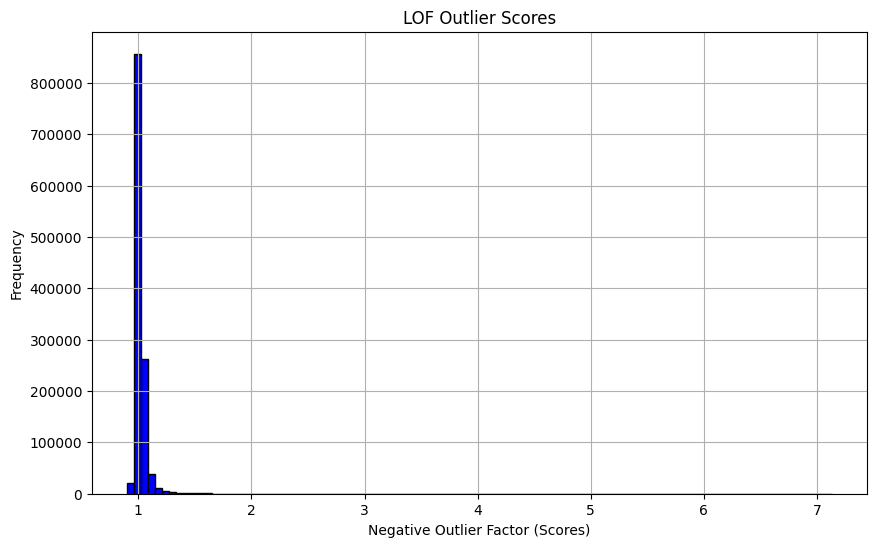

In [14]:
plot_hist(df_lof['outlier_scores'])

### 5. Experimental Setup

In [15]:
def anomaly_counts(t,data):
    outliers = len(data[data['outlier_scores_noise'] > t])
    anomalies = len(data[data['noise'] > 0])
    hits = len(data[(data['outlier_scores_noise'] > t) & (data['noise'] > 0)])
    return outliers, anomalies, hits

In [16]:
LOF_tresholds = [0.5, 0.75, 1.0, 1.5]
sin_params = [1,2,3,4]
gauss_params = [0.1, 0.2, 0.3, 0.4]
point_params = [(5,1),(10,1),(5,2),(10,2)]
shift_params = [1,4,7,10]
trend_params = [0.1, 0.3, 0.5, 0.7]

In [17]:
results=[]
for i in range(50):
    for LOF_threshold in LOF_tresholds:
        
    # Sinusoidal Anomaly
        for amp in sin_params:
            noisy = NoiseMachine.sinusoidal_anomaly(get_rand_sequence(df_lof),100,amp)
            noisy["added_noise"] = noisy["torqueactual"] + noisy["noise"]
            noisy["outlier_scores_noise"] = -lof.decision_function(noisy[["timeindex","added_noise"]])
            
            outliers, anomalies, hits = anomaly_counts(LOF_threshold,noisy)
            results.append(["sinusoidal", LOF_threshold, amp, anomalies, outliers, hits, len(noisy)])

    # Gaussian Anomaly
        for std in gauss_params:
            noisy = NoiseMachine.gaussian_anomaly(get_rand_sequence(df_lof),std)
            noisy["added_noise"] = noisy["torqueactual"] + noisy["noise"]
            noisy["outlier_scores_noise"] = -lof.decision_function(noisy[["timeindex","added_noise"]])

            outliers, anomalies, hits = anomaly_counts(LOF_threshold,noisy)
            results.append(["gaussian", LOF_threshold, std, anomalies, outliers, hits, len(noisy)])

    # Point Anomaly
        for params in point_params:
            noisy = NoiseMachine.point_anomaly(get_rand_sequence(df_lof),params[0],params[1])
            noisy["added_noise"] = noisy["torqueactual"] + noisy["noise"]
            noisy["outlier_scores_noise"] = -lof.decision_function(noisy[["timeindex","added_noise"]])

            outliers, anomalies, hits = anomaly_counts(LOF_threshold,noisy)
            results.append(["point", LOF_threshold, params, anomalies, outliers, hits, len(noisy)])

    # Shift Anomaly
        for strength in shift_params:
            noisy = NoiseMachine.shift_anomaly(get_rand_sequence(df_lof),start = 1000, length = 200, strength = strength)
            noisy["added_noise"] = noisy["torqueactual"] + noisy["noise"]
            noisy["outlier_scores_noise"] = -lof.decision_function(noisy[["timeindex","added_noise"]])

            outliers, anomalies, hits = anomaly_counts(LOF_threshold,noisy)
            results.append(["shift", LOF_threshold, strength, anomalies, outliers, hits, len(noisy)])

   # # Trend Anomaly
   #      for shift in trend_params:
   #          noisy = NoiseMachine.trend_anomaly(get_rand_sequence(df_lof),shift)
   #          noisy["added_noise"] = noisy["torqueactual"] + noisy["noise"]
   #          noisy["outlier_scores_noise"] = -lof.decision_function(noisy[["timeindex","added_noise"]])
   # 
   #          outliers, anomalies, hits = anomaly_counts(LOF_threshold,noisy)
   #          results.append(["trend", LOF_threshold, shift, anomalies, outliers, hits])

C:\Users\Luuk Verkleij\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
C:\Users\Luuk Verkleij\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
C:\Users\Luuk Verkleij\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
C:\Users\Luuk Verkleij\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
C:\Users\Luuk Verkleij\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlie

In [18]:
experiment = pd.DataFrame(results, columns=["anomaly_type", "score_threshold", "params","n_anomalies", "n_outliers", "n_hits","total_obs"])

In [20]:
experiment

,anomaly_type,score_threshold,params,n_anomalies,n_outliers,n_hits,total_obs
0,sinusoidal,0.5,1,99,72,36,2958
1,sinusoidal,0.5,2,99,86,50,5238
2,sinusoidal,0.5,3,99,71,31,4552
3,sinusoidal,0.5,4,99,122,42,6712
4,gaussian,0.5,0.1,2118,16,10,4257
...,...,...,...,...,...,...,...
3195,point,1.5,"(10, 2)",6,2,2,7310
3196,shift,1.5,1,0,0,0,5808
3197,shift,1.5,4,0,2,0,6834
3198,shift,1.5,7,201,2,0,8015


In [21]:
experiment["params"] = experiment["params"].astype(str)

In [22]:
averaged_results = experiment.groupby(['anomaly_type', 'score_threshold', 'params']).mean().reset_index()

In [23]:
averaged_results

,anomaly_type,score_threshold,params,n_anomalies,n_outliers,n_hits,total_obs
0,gaussian,0.50,0.1,2413.02,23.64,13.34,4838.40
1,gaussian,0.50,0.2,2322.22,102.22,58.78,4635.88
2,gaussian,0.50,0.3,2450.64,353.10,198.06,4908.46
3,gaussian,0.50,0.4,2326.64,554.38,298.80,4662.20
4,gaussian,0.75,0.1,2445.48,13.58,7.18,4895.84
...,...,...,...,...,...,...,...
59,sinusoidal,1.00,4,99.00,84.08,45.98,4854.90
60,sinusoidal,1.50,1,99.00,29.64,14.78,4500.82
61,sinusoidal,1.50,2,99.00,62.46,32.40,5199.52
62,sinusoidal,1.50,3,99.00,69.74,40.98,4927.04


In [29]:
pickle_file_path = 'src/signal_processing/LOF_results2.pkl'

In [30]:
averaged_results.to_pickle(pickle_file_path)
print(f"DataFrame saved to {pickle_file_path}")

DataFrame saved to LOF_results2.pkl


In [31]:
loaded_averaged_results = pd.read_pickle(pickle_file_path)


### 6. Evaluation of experiment results

In [32]:
def eval_metrics(results):
    
    eval_results = results.copy()
    
    total_anomalies = eval_results["n_anomalies"].values
    detected_anomalies = eval_results["n_outliers"].values
    true_positives = eval_results["n_hits"].values
    total_observations = eval_results["total_obs"].values
    
    # Calculate False Positives and True Negatives
    false_positives = detected_anomalies - true_positives
    true_negatives = total_observations - (total_anomalies + false_positives)
    
    # Calculate TPR and FPR
    tpr = true_positives / total_anomalies
    fpr = false_positives / (total_observations - total_anomalies)
    
    accuracy = (true_positives + true_negatives) / total_observations
    precision = true_positives / (true_positives + false_positives)
    recall = tpr
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    eval_results["accuracy"] = accuracy
    eval_results["precision"] = precision
    eval_results["recall"] = recall
    eval_results["f1_score"] = f1_score
    
    return eval_results

In [33]:
evaluated_results = eval_metrics(loaded_averaged_results)

In [34]:
evaluated_results

,anomaly_type,score_threshold,params,n_anomalies,n_outliers,n_hits,total_obs,accuracy,precision,recall,f1_score
0,gaussian,0.50,0.1,2413.02,23.64,13.34,4838.40,0.501906,0.564298,0.005528,0.010949
1,gaussian,0.50,0.2,2322.22,102.22,58.78,4635.88,0.502386,0.575034,0.025312,0.048490
2,gaussian,0.50,0.3,2450.64,353.10,198.06,4908.46,0.509496,0.560918,0.080820,0.141283
3,gaussian,0.50,0.4,2326.64,554.38,298.80,4662.20,0.510227,0.538980,0.128426,0.207427
4,gaussian,0.75,0.1,2445.48,13.58,7.18,4895.84,0.500658,0.528719,0.002936,0.005840
...,...,...,...,...,...,...,...,...,...,...,...
59,sinusoidal,1.00,4,99.00,84.08,45.98,4854.90,0.981231,0.546860,0.464444,0.502294
60,sinusoidal,1.50,1,99.00,29.64,14.78,4500.82,0.977986,0.498650,0.149293,0.229789
61,sinusoidal,1.50,2,99.00,62.46,32.40,5199.52,0.981410,0.518732,0.327273,0.401338
62,sinusoidal,1.50,3,99.00,69.74,40.98,4927.04,0.982387,0.587611,0.413939,0.485718


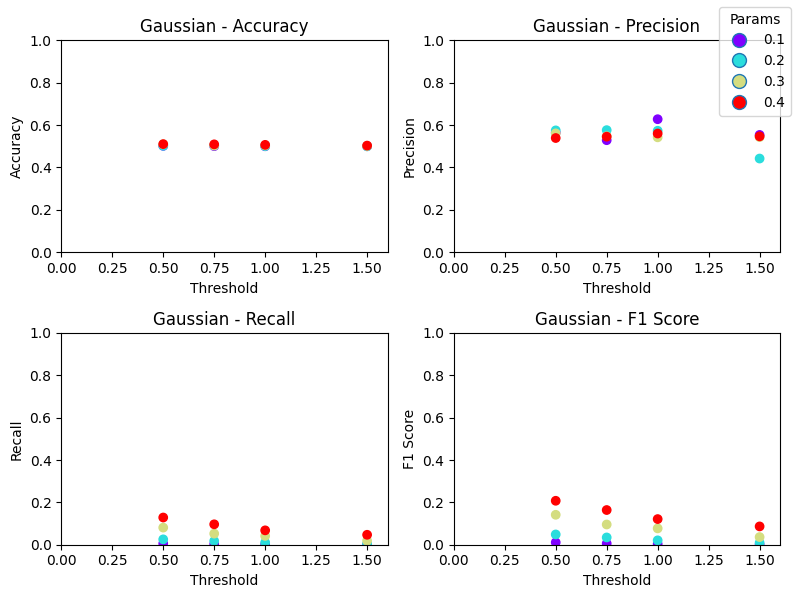

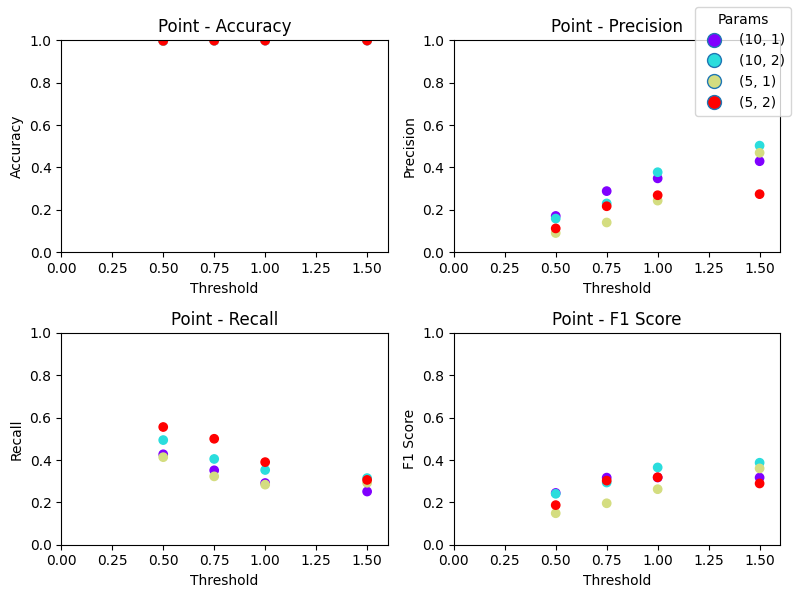

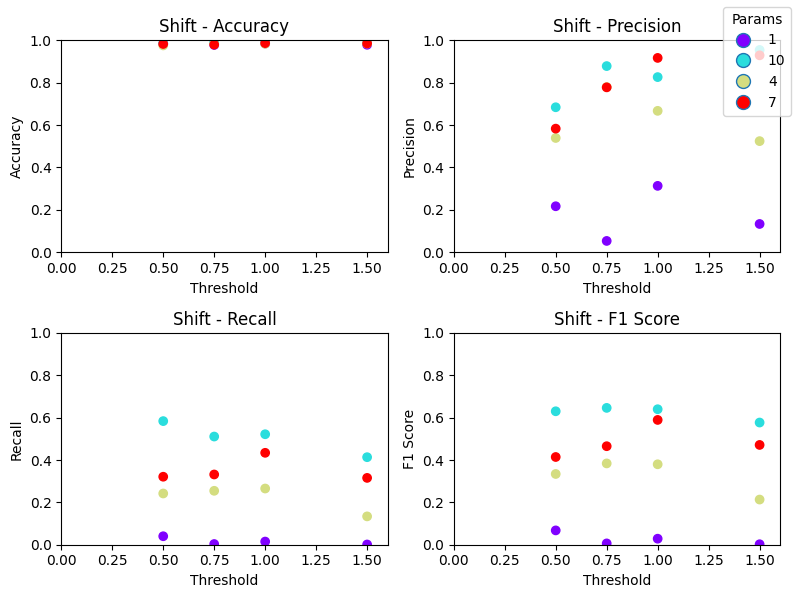

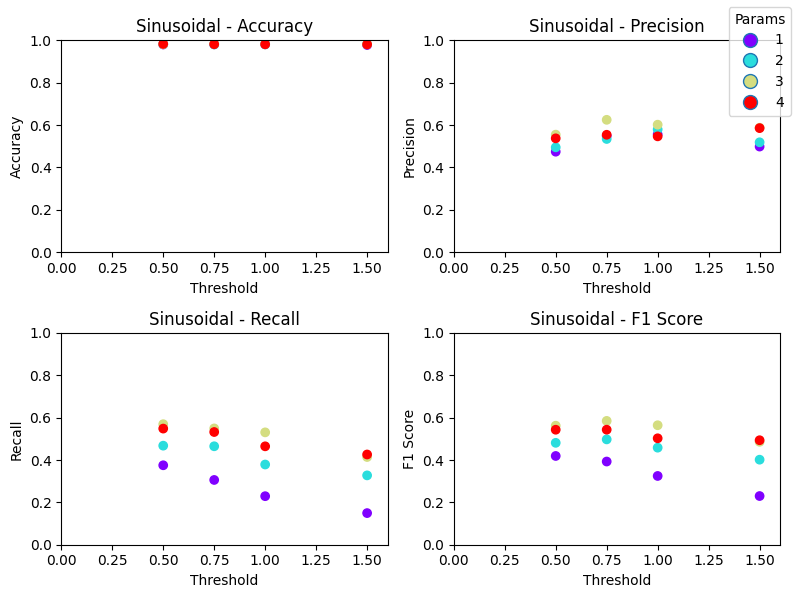

In [35]:
import matplotlib.cm as cm

# Separate data by anomaly type
anomaly_types = evaluated_results['anomaly_type'].unique()

# Plotting
for anomaly in anomaly_types:
    subset = evaluated_results[evaluated_results['anomaly_type'] == anomaly]
    
    # Get unique params for coloring
    unique_params = subset['params'].unique()
    colors = cm.rainbow(np.linspace(0, 1, len(unique_params)))
    color_dict = dict(zip(unique_params, colors))

    fig, axs = plt.subplots(2, 2, figsize=(8, 6))
    
    # Accuracy
    axs[0, 0].scatter(subset['score_threshold'], subset['accuracy'], c=subset['params'].apply(lambda x: color_dict[x]), label=subset['params'])
    axs[0, 0].set_title(f'{anomaly.capitalize()} - Accuracy')
    axs[0, 0].set_xlabel('Threshold')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlim(0, 1.6)
    axs[0, 0].set_ylim(0, 1)
    
    # Precision
    axs[0, 1].scatter(subset['score_threshold'], subset['precision'], c=subset['params'].apply(lambda x: color_dict[x]), label=subset['params'])
    axs[0, 1].set_title(f'{anomaly.capitalize()} - Precision')
    axs[0, 1].set_xlabel('Threshold')
    axs[0, 1].set_ylabel('Precision')
    axs[0, 1].set_xlim(0, 1.6)
    axs[0, 1].set_ylim(0, 1)
    
    # Recall
    axs[1, 0].scatter(subset['score_threshold'], subset['recall'], c=subset['params'].apply(lambda x: color_dict[x]), label=subset['params'])
    axs[1, 0].set_title(f'{anomaly.capitalize()} - Recall')
    axs[1, 0].set_xlabel('Threshold')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].set_xlim(0, 1.6)
    axs[1, 0].set_ylim(0, 1)
    
    # F1 Score
    axs[1, 1].scatter(subset['score_threshold'], subset['f1_score'], c=subset['params'].apply(lambda x: color_dict[x]), label=subset['params'])
    axs[1, 1].set_title(f'{anomaly.capitalize()} - F1 Score')
    axs[1, 1].set_xlabel('Threshold')
    axs[1, 1].set_ylabel('F1 Score')
    axs[1, 1].set_xlim(0, 1.6)
    axs[1, 1].set_ylim(0, 1)
    
    # Create a single legend for all subplots
    handles, labels = [], []
    for param, color in color_dict.items():
        handles.append(plt.Line2D([0, 1], [0, 1], linestyle="none", marker='o', markersize=10, markerfacecolor=color))
        labels.append(str(param))
    fig.legend(handles, labels, title='Params', loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [36]:
pickle_file_path = 'src/signal_processing/LOF_metrics.pkl'

evaluated_results.to_pickle(pickle_file_path)
print(f"DataFrame saved to {pickle_file_path}")

DataFrame saved to LOF_metrics2.pkl


In [37]:
evaluated_results = evaluated_results.round(2)
evaluated_results.to_csv('src/signal_processing/LOF_metrics2.csv',index=False)

### 7. Miscelaneous tests and visualizations

In [38]:
test_seq = get_rand_sequence(df_lof)


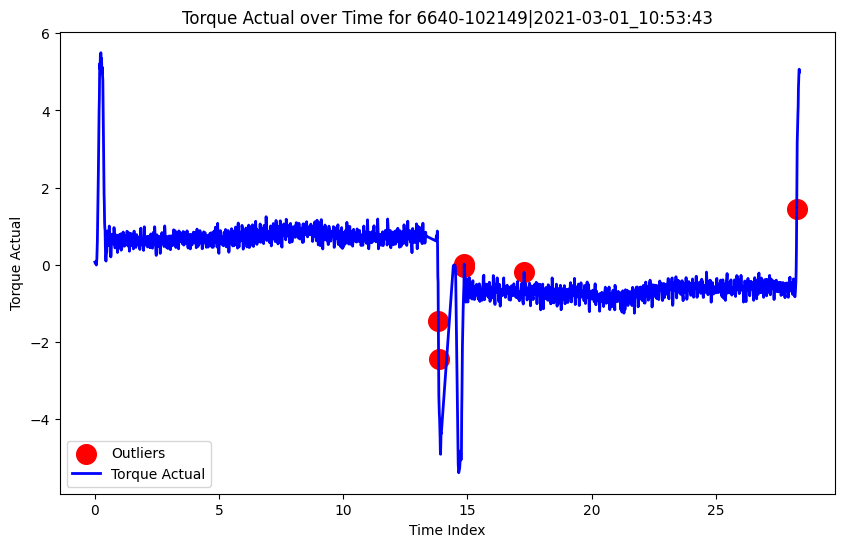

In [39]:
plot_outliers(test_seq, 1.5, "torqueactual","outlier_scores")

In [40]:
noisy = NoiseMachine.sinusoidal_anomaly(test_seq,100)

noisy["added_noise"] = noisy["torqueactual"] + noisy["noise"]
noisy["outlier_scores_noise"] = -lof.decision_function(noisy[["timeindex","added_noise"]])

C:\Users\Luuk Verkleij\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


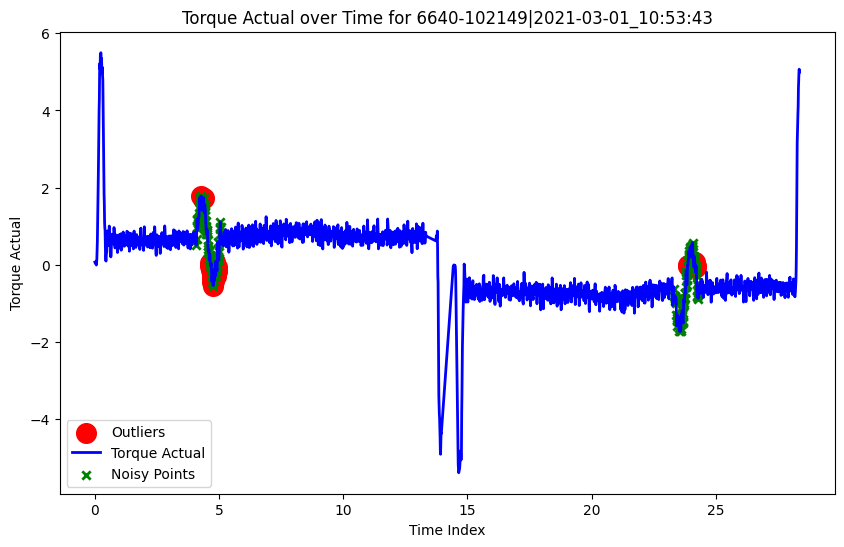

In [41]:
plot_outliers(noisy, 1.0, "added_noise", "outlier_scores_noise")

C:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


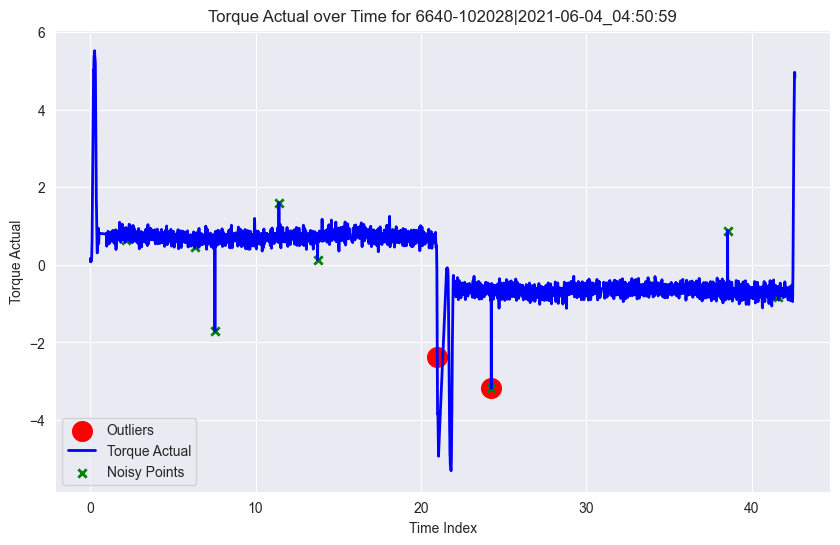

In [20]:
noisy_point = NoiseMachine.point_anomaly(test_seq, 10)

noisy_point["added_noise"] = noisy_point["torqueactual"] + noisy_point["noise"]
noisy_point["outlier_scores_noise"] = -lof.decision_function(noisy_point[["timeindex", "added_noise"]])

plot_outliers(noisy_point, 1.0, "added_noise", "outlier_scores_noise")

In [42]:
noisy_point = NoiseMachine.point_anomaly(test_seq, 10, 3.0)

noisy_point["added_noise"] = noisy_point["torqueactual"] + noisy_point["noise"]
noisy_point["outlier_scores_noise"] = -lof.decision_function(noisy_point[["timeindex", "added_noise"]])

C:\Users\Luuk Verkleij\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


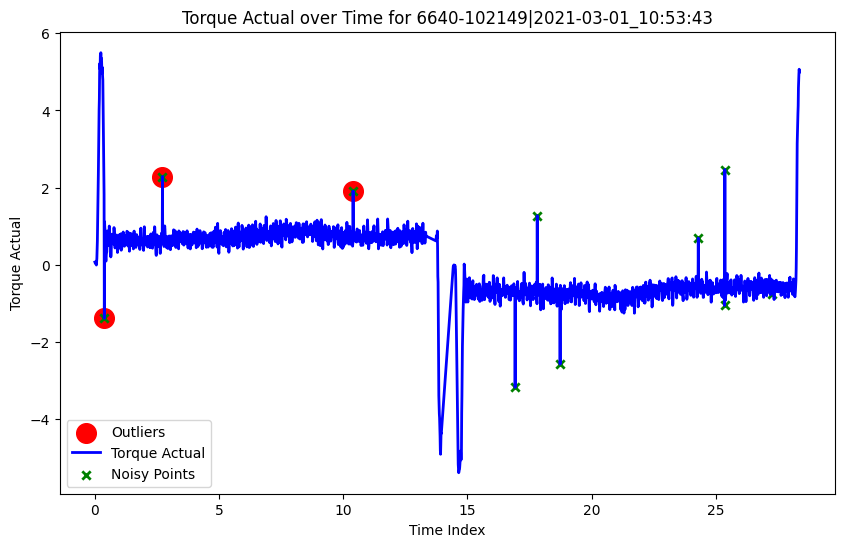

In [43]:

plot_outliers(noisy_point, 1, "added_noise", "outlier_scores_noise")

In [44]:
noisy_point = NoiseMachine.shift_anomaly(test_seq, start=1000, length=200, strength=7.0)

noisy_point["added_noise"] = noisy_point["torqueactual"] + noisy_point["noise"]
noisy_point["outlier_scores_noise"] = -lof.decision_function(noisy_point[["timeindex", "added_noise"]])

C:\Users\Luuk Verkleij\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


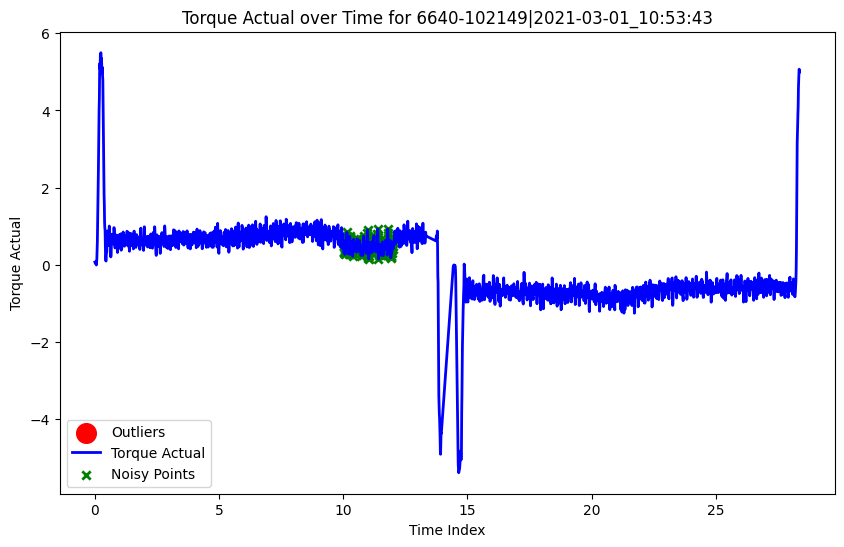

In [45]:

plot_outliers(noisy_point, 1, "added_noise", "outlier_scores_noise")

C:\Users\Luuk Verkleij\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


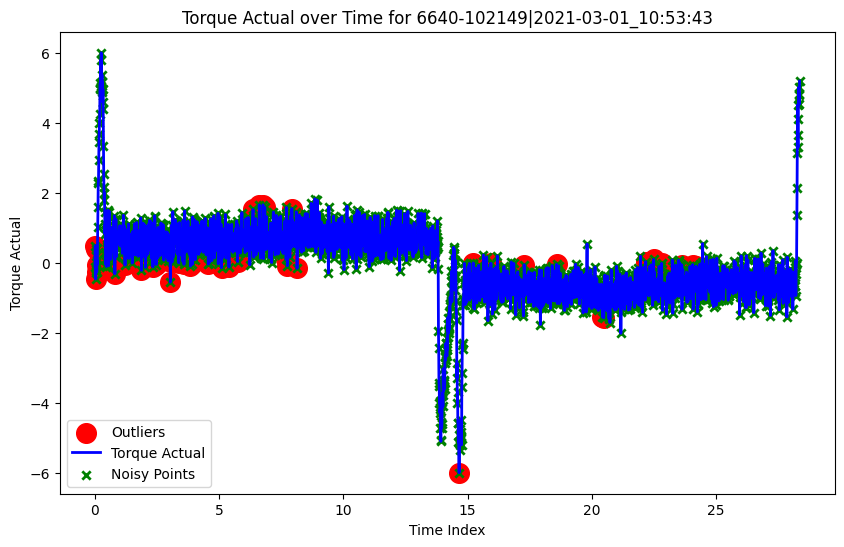

In [46]:
noisy_point = NoiseMachine.gaussian_anomaly(test_seq, 0.3)

noisy_point["added_noise"] = noisy_point["torqueactual"] + noisy_point["noise"]
noisy_point["outlier_scores_noise"] = -lof.decision_function(noisy_point[["timeindex", "added_noise"]])

plot_outliers(noisy_point, 1.0, "added_noise", "outlier_scores_noise")

C:\Users\Luuk Verkleij\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


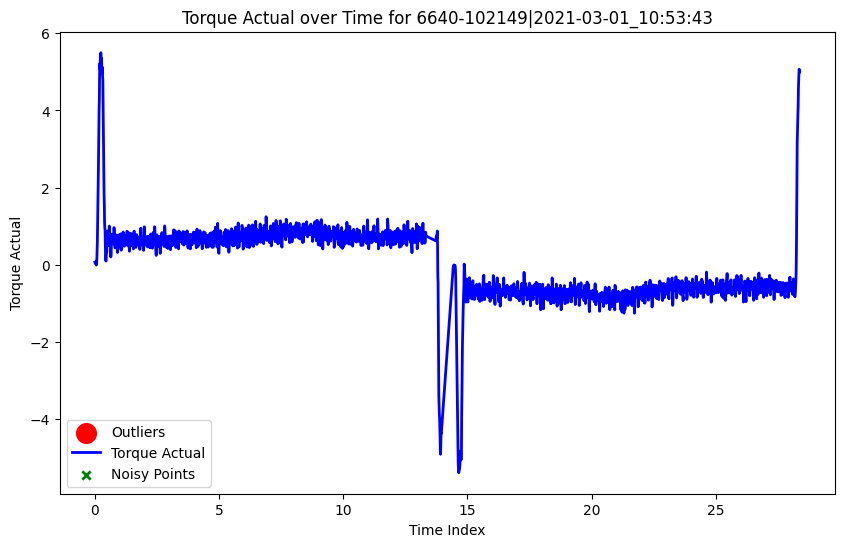

In [47]:
noisy_point = NoiseMachine.gaussian_anomaly(test_seq, 0.0)

noisy_point["added_noise"] = noisy_point["torqueactual"] + noisy_point["noise"]
noisy_point["outlier_scores_noise"] = -lof.decision_function(noisy_point[["timeindex", "torqueactual"]])

plot_outliers(noisy_point, 1.0, "added_noise", "outlier_scores_noise")

In [48]:
noisy

,id,timeindex,torqueactual,outlier_scores,noise,noise_type,added_noise,outlier_scores_noise
0,6640-102149|2021-03-01_10:53:43,0.01,0.067893,0.979163,0.0,sinusoidal,0.067893,-0.080932
1,6640-102149|2021-03-01_10:53:43,0.02,0.043764,0.999976,0.0,sinusoidal,0.043764,-0.063245
2,6640-102149|2021-03-01_10:53:43,0.03,0.030578,0.993486,0.0,sinusoidal,0.030578,-0.058508
3,6640-102149|2021-03-01_10:53:43,0.04,0.054737,1.002237,0.0,sinusoidal,0.054737,-0.062857
4,6640-102149|2021-03-01_10:53:43,0.05,0.049713,1.047791,0.0,sinusoidal,0.049713,-0.024598
...,...,...,...,...,...,...,...,...
2831,6640-102149|2021-03-01_10:53:43,28.32,4.587013,1.132215,0.0,sinusoidal,4.587013,0.063913
2832,6640-102149|2021-03-01_10:53:43,28.33,4.788829,1.042666,0.0,sinusoidal,4.788829,-0.023059
2833,6640-102149|2021-03-01_10:53:43,28.34,4.957682,0.973994,0.0,sinusoidal,4.957682,-0.092373
2834,6640-102149|2021-03-01_10:53:43,28.35,5.069044,1.119608,0.0,sinusoidal,5.069044,0.022879
